In [ ]:
!python3 -m pip install -U git+https://github.com/facebookresearch/demucs#egg=demucs

In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

In [8]:
import matplotlib.pyplot as plt

plt.rc('font', family='NanumBarunGothic')

In [ ]:
!pip uninstall librosa

In [3]:
!pip install librosa==0.8.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 63.8 MB/s eta 0:00:00
  Created wheel for librosa: filename=librosa-0.8.0-py3-none-any.whl size=201368 sha256=d8fd603a2ab27d472484013343ec9ea931603907a2942bb195fa638aae35d238
  Stored in directory: /root/.cache/pip/wheels/bf/b7/85/2f8044306ccec014930aea23ad4852fca9e2584e21c6972bc6
Successfully built librosa


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import pandas as pd
import librosa
import numpy as np
import matplotlib.pyplot as plt
import librosa.display
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm_notebook as tqdm
import os

In [ ]:
import csv
import pandas as pd

csv_file_path = "/content/drive/MyDrive/DataSet/dataset.csv"  # 실제 CSV 파일의 경로로 변경
df = pd.read_csv(csv_file_path)

# "타켓" 열을 기준으로 각 타겟별 데이터 수 계산
target_counts = df["target"].value_counts()

# 결과 출력
print(target_counts)

5     120
12    110
0      40
4      40
6      40
10     40
7      40
3      40
2      40
8      40
1      40
14     40
Name: target, dtype: int64


In [9]:
df = pd.read_csv('/content/drive/MyDrive/DataSet/dataset.csv')

In [10]:
df.head()

filename  fold  target category  src_file
0   1-100032-A-0.wav     1       0   강아지 짓는    100032
1  1-101296-A-19.wav     1       4    천둥 번개    101296
2  1-101296-B-19.wav     1       4    천둥 번개    101296
3   1-110389-A-0.wav     1       0   강아지 짓는    110389
4  1-115521-A-19.wav     1       4    천둥 번개    115521

In [11]:
#fold가 5 ->  테스트 데이터
#fold가 5 이외 -> 학습 데이터
train = df[df['fold']!=5]
valid = df[df['fold']==5]

In [ ]:
wav, sr = librosa.load('/content/drive/MyDrive/DataSet/ESC-50-master/audio/1-100032-A-0.wav', sr=None)
print(f'Sampling rate of the audio is {sr} and length of the audio is {len(wav)/sr} seconds')

In [12]:
import cv2

def spec_to_image(spec, target_shape=(128, 431), eps=1e-6):
    mean = spec.mean()
    std = spec.std()
    spec_norm = (spec - mean) / (std + eps)
    spec_min, spec_max = spec_norm.min(), spec_norm.max()
    spec_scaled = (spec_norm - spec_min) / (spec_max - spec_min)

    # Resize the image to the target shape
    spec_scaled_resized = cv2.resize(spec_scaled, target_shape[::-1], interpolation=cv2.INTER_LINEAR)

    spec_scaled_resized = (spec_scaled_resized * 255).astype(np.uint8)
    return spec_scaled_resized

In [13]:
def get_melspectrogram_db(file_path, sr=None, n_fft=2048, hop_length=512, n_mels=128, fmin=20, fmax=8300, top_db=80):
  wav,sr = librosa.load(file_path,sr=sr)
  if wav.shape[0]<5*sr:
    wav=np.pad(wav,int(np.ceil((5*sr-wav.shape[0])/2)),mode='reflect')
  else:
    wav=wav[:5*sr]
  spec=librosa.feature.melspectrogram(wav, sr=sr, n_fft=n_fft,
              hop_length=hop_length,n_mels=n_mels,fmin=fmin,fmax=fmax)
  spec_db=librosa.power_to_db(spec,top_db=top_db)
  return spec_db

In [14]:
class ESC50Data(Dataset):
  def __init__(self, base, df, in_col, out_col):
    self.df = df
    self.data = []
    self.labels = []
    self.c2i={}
    self.i2c={}
    self.categories = sorted(df[out_col].unique())
    for i, category in enumerate(self.categories):
      self.c2i[category]=i
      self.i2c[i]=category
    for ind in tqdm(range(len(df))):
      row = df.iloc[ind]
      file_path = os.path.join(base,row[in_col])
      self.data.append(spec_to_image(get_melspectrogram_db(file_path))[np.newaxis,...])
      self.labels.append(self.c2i[row['category']])
  def __len__(self):
    return len(self.data)
  def __getitem__(self, idx):
    return self.data[idx], self.labels[idx]

In [15]:
class ESC50Model(nn.Module):
  def __init__(self, input_shape, batch_size=16, num_cats=50):
    super().__init__()
    self.conv1 = nn.Conv2d(1, 32, kernel_size = 3, stride=1, padding=1)
    self.bn1 = nn.BatchNorm2d(32)
    self.conv2 = nn.Conv2d(32, 32, kernel_size = 3, stride=1, padding=1)
    self.bn2 = nn.BatchNorm2d(32)
    self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
    self.bn3 = nn.BatchNorm2d(64)
    self.conv4 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
    self.bn4 = nn.BatchNorm2d(64)
    self.conv5 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
    self.bn5 = nn.BatchNorm2d(128)
    self.conv6 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
    self.bn6 = nn.BatchNorm2d(128)
    self.conv7 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
    self.bn7 = nn.BatchNorm2d(256)
    self.conv8 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
    self.bn8 = nn.BatchNorm2d(256)
    self.dense1 = nn.Linear(256*(((input_shape[1]//2)//2)//2)*(((input_shape[2]//2)//2)//2),500)
    self.dropout = nn.Dropout(0.5)
    self.dense2 = nn.Linear(500, num_cats)
  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(self.bn1(x))
    x = self.conv2(x)
    x = F.relu(self.bn2(x))
    x = F.max_pool2d(x, kernel_size=2)
    x = self.conv3(x)
    x = F.relu(self.bn3(x))
    x = self.conv4(x)
    x = F.relu(self.bn4(x))
    x = F.max_pool2d(x, kernel_size=2)
    x = self.conv5(x)
    x = F.relu(self.bn5(x))
    x = self.conv6(x)
    x = F.relu(self.bn6(x))
    x = F.max_pool2d(x, kernel_size=2)
    x = self.conv7(x)
    x = F.relu(self.bn7(x))
    x = self.conv8(x)
    x = F.relu(self.bn8(x))
    x = x.view(x.size(0),-1)
    x = F.relu(self.dense1(x))
    x = self.dropout(x)
    x = self.dense2(x)
    return x


In [ ]:
filename = valid[valid['category']=='mouse_click'].iloc[0]['filename']
wav, sr = librosa.load('/content/drive/MyDrive/DataSet/ESC-50-master/audio/'+filename, sr=None)
librosa.display.waveplot(wav, sr)

In [ ]:
librosa.display.specshow(spec_to_image(get_melspectrogram_db('/content/drive/MyDrive/DataSet/ESC-50-master/audio/'+filename, sr)), cmap='viridis')

In [16]:
train_data = ESC50Data('/content/drive/MyDrive/DataSet/ESC-50-master/audio', train, 'filename', 'category')

<ipython-input-14-29e94fe7e1ff>:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for ind in tqdm(range(len(df))):


  0%|          | 0/513 [00:00<?, ?it/s]

In [17]:
valid_data = ESC50Data('/content/drive/MyDrive/DataSet/ESC-50-master/audio', valid, 'filename', 'category')

<ipython-input-14-29e94fe7e1ff>:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for ind in tqdm(range(len(df))):


  0%|          | 0/117 [00:00<?, ?it/s]

In [18]:
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=16, shuffle=True)

In [19]:
if torch.cuda.is_available():
  device=torch.device('cuda:0')
else:
  device=torch.device('cpu')

In [20]:
model = ESC50Model(input_shape=(1,128,431), batch_size=16, num_cats=50).to(device)

In [21]:
def setlr(optimizer, lr):
  for param_group in optimizer.param_groups:
    param_group['lr'] = lr
  return optimizer

In [22]:
loss_fn = nn.CrossEntropyLoss()
learning_rate = 2e-5
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
epochs = 60
train_losses = []
valid_losses = []

In [23]:
def train(model, loss_fn, train_loader, valid_loader, epochs, optimizer, train_losses, valid_losses, change_lr=None):
  for epoch in tqdm(range(1,epochs+1)):
    model.train()
    batch_losses=[]
    if change_lr:
      optimizer = change_lr(optimizer, epoch)
    for i, data in enumerate(train_loader):
      x, y = data
      optimizer.zero_grad()
      x = x.to(device, dtype=torch.float32)
      y = y.to(device, dtype=torch.long)
      y_hat = model(x)
      loss = loss_fn(y_hat, y)
      loss.backward()
      batch_losses.append(loss.item())
      optimizer.step()
    train_losses.append(batch_losses)
    print(f'Epoch - {epoch} Train-Loss : {np.mean(train_losses[-1])}')
    model.eval()
    batch_losses=[]
    trace_y = []
    trace_yhat = []
    for i, data in enumerate(valid_loader):
      x, y = data
      x = x.to(device, dtype=torch.float32)
      y = y.to(device, dtype=torch.long)
      y_hat = model(x)
      loss = loss_fn(y_hat, y)
      trace_y.append(y.cpu().detach().numpy())
      trace_yhat.append(y_hat.cpu().detach().numpy())
      batch_losses.append(loss.item())
    valid_losses.append(batch_losses)
    trace_y = np.concatenate(trace_y)
    trace_yhat = np.concatenate(trace_yhat)
    accuracy = np.mean(trace_yhat.argmax(axis=1)==trace_y)
    print(f'Epoch - {epoch} Valid-Loss : {np.mean(valid_losses[-1])} Valid-Accuracy : {accuracy}')

In [ ]:
# 실행 X
def lr_decay(optimizer, epoch):
  if epoch%20==0:
    new_lr = learning_rate / (10**(epoch//20))
    optimizer = setlr(optimizer, new_lr)
    print(f'Changed learning rate to {new_lr}')
  return optimizer
train(model, loss_fn, train_loader, valid_loader, epochs, optimizer, train_losses, valid_losses, lr_decay)

In [ ]:
# 실행 X
tl = np.asarray(train_losses).ravel()
vl = np.asarray(valid_losses).ravel()
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(tl)
plt.legend(['Train Loss'])
plt.subplot(1,2,2)
plt.plot(vl,'orange')
plt.legend(['Valid Loss'])


NameError: ignored

In [24]:
from torchvision.models import resnet34
resnet_model = resnet34(pretrained=True)
 # 클래스 수정해야함
 # resnet_model.fc = nn.Linear(512,50) -> 13개 class로
resnet_model.fc = nn.Linear(512,13)
resnet_model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
resnet_model = resnet_model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/usr/local/lib/python3.10/dist-packages/torchvision/image.so: undefined symbol: _ZN3c104cuda9SetDeviceEi'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. 

In [25]:
learning_rate = 2e-4
optimizer = optim.Adam(resnet_model.parameters(), lr=learning_rate)
epochs = 50
loss_fn = nn.CrossEntropyLoss()
resnet_train_losses=[]
resnet_valid_losses=[]
def lr_decay(optimizer, epoch):
  if epoch%10==0:
    new_lr = learning_rate / (10**(epoch//10))
    optimizer = setlr(optimizer, new_lr)
    print(f'Changed learning rate to {new_lr}')
  return optimizer
train(resnet_model, loss_fn, train_loader, valid_loader, epochs, optimizer, resnet_train_losses, resnet_valid_losses, lr_decay)

<ipython-input-23-46ce3a7195ab>:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm(range(1,epochs+1)):


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch - 1 Train-Loss : 1.1539339116125396
Epoch - 1 Valid-Loss : 0.9162519164383411 Valid-Accuracy : 0.7777777777777778
Epoch - 2 Train-Loss : 0.5751945769244974
Epoch - 2 Valid-Loss : 0.616032313555479 Valid-Accuracy : 0.7777777777777778
Epoch - 3 Train-Loss : 0.4563113432942015
Epoch - 3 Valid-Loss : 0.6316161472350359 Valid-Accuracy : 0.7948717948717948
Epoch - 4 Train-Loss : 0.29307152725981944
Epoch - 4 Valid-Loss : 0.7376954779028893 Valid-Accuracy : 0.811965811965812
Epoch - 5 Train-Loss : 0.2364820514551618
Epoch - 5 Valid-Loss : 0.4165730527602136 Valid-Accuracy : 0.8547008547008547
Epoch - 6 Train-Loss : 0.2896516934940309
Epoch - 6 Valid-Loss : 0.49599613808095455 Valid-Accuracy : 0.8376068376068376
Epoch - 7 Train-Loss : 0.19560973950181948
Epoch - 7 Valid-Loss : 0.28357340581715107 Valid-Accuracy : 0.9401709401709402
Epoch - 8 Train-Loss : 0.17855752725154161
Epoch - 8 Valid-Loss : 0.6977892387658358 Valid-Accuracy : 0.8205128205128205
Epoch - 9 Train-Loss : 0.238376875210

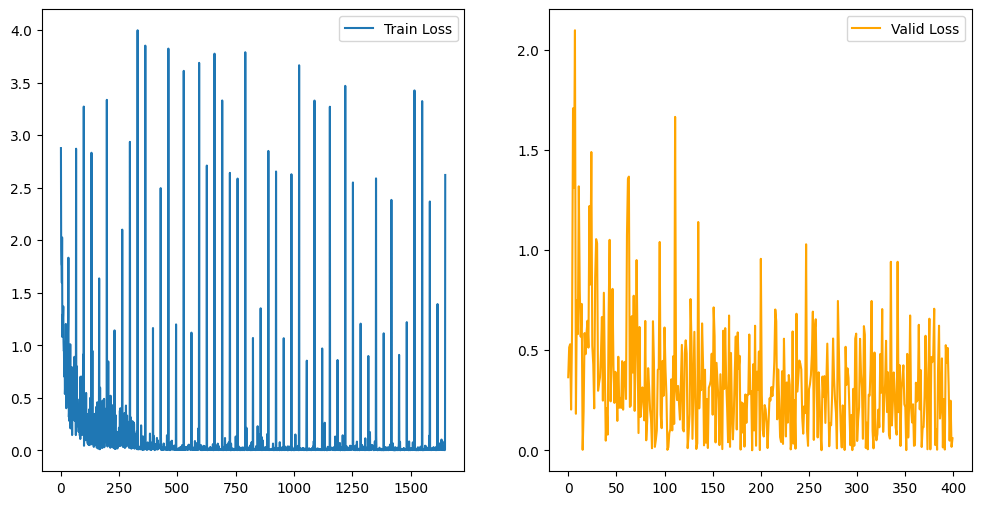

In [26]:
tl = np.asarray(resnet_train_losses).ravel()
vl = np.asarray(resnet_valid_losses).ravel()
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(tl)
plt.legend(['Train Loss'])
plt.subplot(1,2,2)
plt.plot(vl,'orange')
plt.legend(['Valid Loss'])


In [27]:
with open('esc50resnet.pth','wb') as f:
  torch.save(resnet_model, f)

In [28]:
import pickle
with open('indtocat.pkl','wb') as f:
  pickle.dump(train_data.i2c, f)

In [32]:
import shutil

# 모델 파일을 Google 드라이브로 복사
shutil.copy('esc50resnet.pth', '/content/drive/MyDrive/Colab Notebooks/GraduationProject')
shutil.copy('indtocat.pkl','/content/drive/MyDrive/Colab Notebooks/GraduationProject')

'/content/drive/MyDrive/Colab Notebooks/GraduationProject/indtocat.pkl'

In [29]:
# demucs
import io
import subprocess as sp
import sys
import select
from typing import Dict, Tuple, Optional, IO
from pathlib import Path

from google.colab import files

def copy_process_streams(process: sp.Popen):
    def raw(stream: Optional[IO[bytes]]) -> IO[bytes]:
        assert stream is not None
        if isinstance(stream, io.BufferedIOBase):
            stream = stream.raw
        return stream

    p_stdout, p_stderr = raw(process.stdout), raw(process.stderr)
    stream_by_fd: Dict[int, Tuple[IO[bytes], io.StringIO, IO[str]]] = {
        p_stdout.fileno(): (p_stdout, sys.stdout),
        p_stderr.fileno(): (p_stderr, sys.stderr),
    }
    fds = list(stream_by_fd.keys())

    while fds:
        ready, _, _ = select.select(fds, [], [])
        for fd in ready:
            p_stream, std = stream_by_fd[fd]
            raw_buf = p_stream.read(2 ** 16)
            if not raw_buf:
                fds.remove(fd)
                continue
            buf = raw_buf.decode()
            std.write(buf)
            std.flush()

def separate(input_audio_path, output_folder_path):
    cmd = ["python3", "-m", "demucs.separate", "-o", str(output_folder_path), "-n", model]
    if mp3:
        cmd += ["--mp3", f"--mp3-bitrate={mp3_rate}"]
    if float32:
        cmd += ["--float32"]
    if int24:
        cmd += ["--int24"]
    if two_stems is not None:
        cmd += [f"--two-stems={two_stems}"]
    p = sp.Popen(cmd + [str(input_audio_path)], stdout=sp.PIPE, stderr=sp.PIPE)
    copy_process_streams(p)
    p.wait()
    if p.returncode != 0:
        print("Command failed, something went wrong.")

def separate_and_save(input_audio_path, output_folder_path):
    output_folder_path = Path(output_folder_path)
    output_folder_path.mkdir(exist_ok=True)
    separate(input_audio_path, output_folder_path)

In [30]:
# 분리
if __name__ == "__main__":
    model = "htdemucs"
    mp3 = False  # WAV 형식으로 저장
    float32 = False
    int24 = False
    two_stems = None  # None으로 설정하면 모든 소스를 분리
    in_path = '/content/'
    output_folder = '/content/drive/MyDrive/ModelTest/output'  # 분리된 소리를 저장할 폴더 경로

    input_audio_file = "/content/audio6.m4a"  # 입력으로 사용할 오디오 파일 경로

    separate_and_save(input_audio_file, output_folder)

Downloading: "https://dl.fbaipublicfiles.com/demucs/hybrid_transformer/955717e8-8726e21a.th" to /root/.cache/torch/hub/checkpoints/955717e8-8726e21a.th
100%|██████████| 80.2M/80.2M [00:00<00:00, 96.0MB/s]
File /content/audio6.m4a does not exist. If the path contains spaces, please try again after surrounding the entire path with quotes "".


Selected model is a bag of 1 models. You will see that many progress bars per track.
Separated tracks will be stored in /content/drive/MyDrive/ModelTest/output/htdemucs


In [ ]:
import IPython
import pickle
with open('/content/drive/MyDrive/model/indtocat.pkl','rb') as f:
  indtocat = pickle.load(f)
filename='/content/drive/MyDrive/ModelTest/output/htdemucs/audio6/bass.wav'
spec=spec_to_image(get_melspectrogram_db(filename))
spec_t=torch.tensor(spec).to(device, dtype=torch.float32)
pr=resnet_model.forward(spec_t.reshape(1,1,*spec_t.shape))
ind = pr.argmax(dim=1).cpu().detach().numpy().ravel()[0]
print(indtocat[ind])
IPython.display.display(IPython.display.Audio(filename=filename))

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
filename='/content/drive/MyDrive/ModelTest/output/htdemucs/audio6/drums.wav'
spec=spec_to_image(get_melspectrogram_db(filename))
spec_t=torch.tensor(spec).to(device, dtype=torch.float32)
pr=resnet_model.forward(spec_t.reshape(1,1,*spec_t.shape))
ind = pr.argmax(dim=1).cpu().detach().numpy().ravel()[0]
print(indtocat[ind])
IPython.display.display(IPython.display.Audio(filename=filename))

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
filename='/content/drive/MyDrive/ModelTest/output/htdemucs/audio6/other.wav'
spec=spec_to_image(get_melspectrogram_db(filename))
spec_t=torch.tensor(spec).to(device, dtype=torch.float32)
pr=resnet_model.forward(spec_t.reshape(1,1,*spec_t.shape))
ind = pr.argmax(dim=1).cpu().detach().numpy().ravel()[0]
print(indtocat[ind])
IPython.display.display(IPython.display.Audio(filename=filename))

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
filename='/content/drive/MyDrive/ModelTest/output/htdemucs/audio6/vocals.wav'
spec=spec_to_image(get_melspectrogram_db(filename))
spec_t=torch.tensor(spec).to(device, dtype=torch.float32)
pr=resnet_model.forward(spec_t.reshape(1,1,*spec_t.shape))
ind = pr.argmax(dim=1).cpu().detach().numpy().ravel()[0]
print(indtocat[ind])
IPython.display.display(IPython.display.Audio(filename=filename))

train


In [ ]:
filename='/content/04_01_000094_210721_SN.wav'
spec=spec_to_image(get_melspectrogram_db(filename))
spec_t=torch.tensor(spec).to(device, dtype=torch.float32)
pr=resnet_model.forward(spec_t.reshape(1,1,*spec_t.shape))
ind = pr.argmax(dim=1).cpu().detach().numpy().ravel()[0]
print(indtocat[ind])
IPython.display.display(IPython.display.Audio(filename=filename))

Output hidden; open in https://colab.research.google.com to view.